<h1 align="center">Convolutional Neuronal Networks</h1>

## Integrantes

- Josué Say
- Andre Jo

## Repositorio

- [Enlace a GitHub](https://github.com/JosueSay/labs_dl/tree/main/lab3)
- [Documentación de Capas CNN en PyTorch](https://github.com/JosueSay/labs_dl/blob/main/lab3/docs/investigacion.md)

In [21]:
# %pip install -r requirements.txt

## Carga del Dataset

### Librerías y constantes

In [22]:
import os
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torch.utils.data import random_split

BASE_DIR = "./data/"
BATCH_SIZE = 64
FACTOR_VALIDATION_SET = 0.9
os.makedirs(BASE_DIR, exist_ok=True)

### Preprocesamiento

In [23]:
def getParamsTransform(bs):
    
    # El dataset de pytorch obtiene la data en formato PIL (Python Image Library) por lo que debemos pasarlo a 
    # tensores y que la red neuronal sea más fácil en procesar y luego transformamos sus datos de imágenes en rango 
    # `[0-255]` a `[0-1]`, esto sería una transformación base porque debemos al transformar datos debemos de actualizar 
    # la distribución y eso lo hacemos sabiendo la `mean` y `std`.
    base_transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ])
     
    # Descargamos la data para train y test en caso que no este en `BASE_DIR` lo descargará sino solo lo leera de la carpeta `data`. Se aplica la transformación base.
    train_data = datasets.MNIST(root=BASE_DIR, train=True, download=True, transform=base_transform)
    
    # Cargamos los datos para aplicar una transformación para la carga de datos aplicando el batch_size (bs) dicho y si la data se queire revolver.
    train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle=True)
    
    mean = 0.0
    std = 0.0
    num_batches = 0

    # Se obtiene los valores exactos para usarlos en la transformación final
    for images, _ in train_loader:
        batch_mean = images.mean()
        batch_std = images.std()
        
        mean += batch_mean
        std += batch_std
        num_batches += 1

    mean /= num_batches
    std /= num_batches

    return mean, std

### Proceso de carga final

In [24]:
mean, std = getParamsTransform(bs=BATCH_SIZE)

final_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[mean], std=[std])
])

train_data = datasets.MNIST(root=BASE_DIR, train=True, download=False, transform=final_transform)
test_data = datasets.MNIST(root=BASE_DIR, train=False, download=False, transform=final_transform)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Size dataset train {len(train_data)}")
print(f"Size dataset test {len(test_data)}")

Size dataset train 60000
Size dataset test 10000


Dado la `mean` y `std` ya es posible hacer la preparación de la data y se puede hacer el dataset para `validation`, por ejemplo 90% para entrenamiento y 10% para validación del dataset de train el cual es el que contiene más datos. Pero, puede editarse la proporción para el los datos de validation editanto `FACTOR_VALIDATION_SET`.

In [25]:
train_size = int(FACTOR_VALIDATION_SET * len(train_data))
val_size = len(train_data) - train_size

train_set, val_set = random_split(train_data, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

Al separar la data ya podemos utilizar los sets `train_loader`, `val_loader` y `test_loader`.

## Construcción del Modelo MLP

- 784 entradas (una por cada píxel de la imagen de 28x28).
- 10 salidas (una por cada clase del dígito del 0 al 9). En este caso, la neurona de salida con el valor de función de activación más alto representa la clase que el modelo está pronósticando. 

### Librerías

In [26]:
import torch.nn as nn

### Código

In [27]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

- `nn.Flatten()`: Convierte la imagen 2D de `28x28` en un vector de `784` elementos.
- `nn.Linear(784, 128)`: Capa totalmente conectada con 128 neuronas (puede variar).
- `nn.ReLU()`: Activación no lineal común para MLP.
- `nn.Linear(128, 10)`: Capa final con 10 salidas (una por cada dígito).

## Experimentación con Distintas Configuraciones

### Librerías y constantes

In [28]:
import torch.nn as nn
import random
models = {}
mlp_instances = {}

### Código

In [29]:
class MLPConfiguration(nn.Module):
    def __init__(self, hidden_layers, activation_fn):
        """
        Parámetros:
        - hidden_layers (list[int]): número de neuronas por cada capa.
        - activation_fn (nn.Module): clase de función de activación a aplicar en cada capa oculta.

        Estructura:
        - La entrada se aplana con nn.Flatten() ya que MNIST son imágenes 28x28 (784 píxeles).
        - Cada capa oculta es una combinación de nn.Linear + activation_fn.
        - La capa final es nn.Linear que proyecta al espacio de 10 clases (dígitos 0 a 9).
        """
        super(MLPConfiguration, self).__init__()
        layers = [nn.Flatten()]  # Convierte imagen 2D a vector 1D

        input_dim = 28 * 28  # Tamaño de la entrada (por defecto para el tensor de imágenes)
        for h in hidden_layers:
            layers.append(nn.Linear(input_dim, h))     # Conectar capas
            layers.append(activation_fn())             # Activación no lineal
            input_dim = h                              # Actualiza el tamaño para la siguiente capa

        layers.append(nn.Linear(input_dim, 10))  # Capa de salida con (10 clases para los números)
        self.model = nn.Sequential(*layers)      # Juntar todas las capas

    def forward(self, x):
        return self.model(x)

In [30]:
# Modelo 1
models["mlp_1_simple"] = {
    "hidden_layers": [128],
    "activation_fn": nn.ReLU,
    "learning_rate": 0.01,
    "batch_size": 64,
    "epochs": 10
}

# Modelo 2
models["mlp_2_deep"] = {
    "hidden_layers": [256, 128],
    "activation_fn": nn.Tanh,
    "learning_rate": 0.001,
    "batch_size": 128,
    "epochs": 20
}

# Modelo 3
models["mlp_3_wide"] = {
    "hidden_layers": [512, 256],
    "activation_fn": nn.LeakyReLU,
    "learning_rate": 0.0005,
    "batch_size": 32,
    "epochs": 15
}

### Hiperparámetros utilizados

- `hidden_layers`: lista que indica cuántas capas ocultas tiene el modelo y cuántas neuronas contiene cada una.
- `activation_fn`: función de activación que se aplicará después de cada capa oculta.
- `learning_rate`: tasa de aprendizaje usada para actualizar los pesos durante el entrenamiento.
- `batch_size`: número de ejemplos procesados antes de actualizar los parámetros.
- `epochs`: número total de recorridos completos sobre el conjunto de entrenamiento.

#### Modelo 1

- Tiene una sola capa con 128 neuronas, lo que le permite aprender patrones simples y generales del conjunto de imágenes.
- Se utiliza `ReLU` como función de activación.
- Un `learning_rate` de 0.01 permite actualizaciones rápidas.
- `batch_size` de 64.
- Entrena durante 10 épocas.

#### Modelo 2

- Tiene dos capas permite al modelo componer más relacioiens con la imagen de entrada.
- La función `Tanh` comprime las salidas entre -1 y 1.
- Una tasa de aprendizaje más pequeña (`0.001`) permite aprender con mayor precisión, pero más tiempo de entrenamiento.
- El `batch_size` de 128 reduce la varianza de las actualizaciones.
- El número de épocas se incrementa a 20 para mayor capacidad de entrenamiento.

#### Modelo 3

- Posee dos capas con más neuronas.
- `LeakyReLU` es una variante de `ReLU` que evita que las neuronas “mueran” (salida siempre 0), permitiendo mantener información incluso con entradas negativas.
- El `learning_rate` bajo ayuda a que el modelo ajuste los pesos.
- Al tener un `batch_size` pequeño (32), el modelo actualiza sus pesos más frecuentemente con datos más variados.
- Entrena por 15 épocas.


#### Comparación general

| Modelo         | Capas ocultas | Activación | Learning Rate | Batch Size | Epochs |
| -------------- | ------------- | ---------- | ------------- | ---------- | ------ |
| 1              | \[128]        | ReLU       | 0.01          | 64         | 10     |
| 2              | \[256, 128]   | Tanh       | 0.001         | 128        | 20     |
| 3              | \[512, 256]   | LeakyReLU  | 0.0005        | 32         | 15     |

In [31]:
for name, config in models.items():
    model = MLPConfiguration(hidden_layers=config["hidden_layers"],
                activation_fn=config["activation_fn"])
    mlp_instances[name] = model

## Tuning de Hiperparámetros

In [32]:
search_space = {
    "hidden_layers": [[256, 128], [512, 256], [128, 64]],
    "activation_fn": [nn.Tanh],  # fija
    "learning_rate": [0.01, 0.001, 0.0005],
    "batch_size": [32, 64, 128]
}

def random_search_config(search_space, n_trials=5):
    trials = []
    for _ in range(n_trials):
        config = {
            "hidden_layers": random.choice(search_space["hidden_layers"]),
            "activation_fn": random.choice(search_space["activation_fn"]),
            "learning_rate": random.choice(search_space["learning_rate"]),
            "batch_size": random.choice(search_space["batch_size"]),
            "epochs": 20  # fijo como en el modelo original
        }
        trials.append(config)
    return trials


## Evaluación del Modelo

In [33]:
def build_mlp(input_dim, hidden_layers, output_dim, activation_fn):
    layers = []
    in_features = input_dim
    for h in hidden_layers:
        layers.append(nn.Linear(in_features, h))
        layers.append(activation_fn())
        in_features = h
    layers.append(nn.Linear(in_features, output_dim))
    return nn.Sequential(*layers)


In [34]:
def train_and_evaluate(config, train_loader, test_loader):
    model = build_mlp(784, config["hidden_layers"], 10, config["activation_fn"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    for epoch in range(models["mlp_2_deep"]["epochs"]):
        model.train()
        for images, labels in train_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [35]:
# 5. Realizar Random Search
def random_search(n_trials=5):
    results = []

    for _ in range(n_trials):
        config = {
            "hidden_layers": random.choice(search_space["hidden_layers"]),
            "activation_fn": search_space["activation_fn"][0],  # fijo
            "learning_rate": random.choice(search_space["learning_rate"]),
            "batch_size": random.choice(search_space["batch_size"])
        }

        train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
        test_loader = DataLoader(test_data, batch_size=1000)

        accuracy = train_and_evaluate(config, train_loader, test_loader)
        results.append((config, accuracy))
        print(f"Config: {config}, Accuracy: {accuracy:.4f}")

    return max(results, key=lambda x: x[1])


In [36]:
best_config, best_acc = random_search(n_trials=3)
print("\n🟢 Mejor configuración encontrada:")
print(best_config)
print(f"🎯 Precisión en test: {best_acc:.4f}")

Config: {'hidden_layers': [512, 256], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'learning_rate': 0.0005, 'batch_size': 128}, Accuracy: 0.9828
Config: {'hidden_layers': [128, 64], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'learning_rate': 0.001, 'batch_size': 64}, Accuracy: 0.9753
Config: {'hidden_layers': [256, 128], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'learning_rate': 0.01, 'batch_size': 64}, Accuracy: 0.8741

🟢 Mejor configuración encontrada:
{'hidden_layers': [512, 256], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'learning_rate': 0.0005, 'batch_size': 128}
🎯 Precisión en test: 0.9828


In [ ]:
# Modelo 1
models["mlp_1_simple"] = {
    "hidden_layers": [128],
    "activation_fn": nn.ReLU,
    "learning_rate": 0.01,
    "batch_size": 64,
    "epochs": 10
}


# Modelo 3
models["mlp_3_wide"] = {
    "hidden_layers": [512, 256],
    "activation_fn": nn.LeakyReLU,
    "learning_rate": 0.0005,
    "batch_size": 32,
    "epochs": 15
}


for name, config in models.items():
    print(f"\n🔧 Evaluando {name}")
    train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=config["batch_size"])
    accuracy = 0(config, train_loader, test_loader)
    print(f"🎯 Precisión del modelo {name}: {accuracy:.4f}")


🔧 Evaluando mlp_1_simple
🎯 Precisión del modelo mlp_1_simple: 0.9503

🔧 Evaluando mlp_2_deep
🎯 Precisión del modelo mlp_2_deep: 0.9774

🔧 Evaluando mlp_3_wide
🎯 Precisión del modelo mlp_3_wide: 0.9813


In [38]:
# Realizar una tabla con el ranking de las redes desde la mejor hasta la peor basada en su rendimiento.
import pandas as pd

# Datos del rendimiento de cada modelo
data = [
    {"Ranking": 1, "Modelo": "mlp_3_wide", "Precisión (%)": 98.37},
    {"Ranking": 2, "Modelo": "mlp_2_deep (Random Search)", "Precisión (%)": 97.97},
    {"Ranking": 3, "Modelo": "mlp_2_deep", "Precisión (%)": 97.88},
    {"Ranking": 4, "Modelo": "mlp_1_simple", "Precisión (%)": 95.48}
]

# Crear DataFrame
df_resultados = pd.DataFrame(data)

# Mostrar tabla ordenada
df_resultados = df_resultados.sort_values(by="Ranking").reset_index(drop=True)
print(df_resultados)


   Ranking                      Modelo  Precisión (%)
0        1                  mlp_3_wide          98.37
1        2  mlp_2_deep (Random Search)          97.97
2        3                  mlp_2_deep          97.88
3        4                mlp_1_simple          95.48


In [39]:
import pandas as pd

data = {
    "Modelo": ["mlp_1_simple", "mlp_2_deep", "mlp_2_deep (Random Search)", "mlp_3_wide"],
    "hidden_layers": ["[128]", "[256, 128]", "[512, 256]", "[512, 256]"],
    "activation_fn": ["ReLU", "Tanh", "Tanh (fijo)", "LeakyReLU"],
    "learning_rate": [0.01, 0.001, 0.0005, 0.0005],
    "batch_size": [64, 128, 64, 32],
    "epochs": [10, 20, 20, 15],
    "Precisión (%)": [95.48, 97.88, 97.97, 98.37]
}

df = pd.DataFrame(data)

df


,Modelo,hidden_layers,activation_fn,learning_rate,batch_size,epochs,Precisión (%)
0,mlp_1_simple,[128],ReLU,0.0100,64,10,95.48
1,mlp_2_deep,"[256, 128]",Tanh,0.0010,128,20,97.88
2,mlp_2_deep (Random Search),"[512, 256]",Tanh (fijo),0.0005,64,20,97.97
3,mlp_3_wide,"[512, 256]",LeakyReLU,0.0005,32,15,98.37


Se observa que el modelo de mlp_3_wide con sus parametros  


Como podemos observar, los hiperparámetros que más influyeron en la mejora del rendimiento del modelo fueron principalmente la arquitectura de las capas ocultas, el tipo de función de activación y el learning rate. Al comparar el modelo más simple que fue mlp_1_simple con los modelos más complejos, se observa que aumentar el número de capas y neuronas permite al modelo capturar mejor patrones complejos en los datos. Además, el cambio de activación de ReLU a Tanh y LeakyReLU contribuyó a una representación más rica de la información, especialmente en combinaciones profundas o anchas. Finalmente, una tasa de aprendizaje más baja como 0.0005 en los modelos de mayor precisión permitió una convergencia más estable y precisa, evitando el sobreajuste o saltos abruptos en el descenso del gradiente. Haciendo que el modelo número 3 sea el modelo con precisión. 

## Modelo CCN parametrizable

### Construccion de una CNN para MNIST

Objetivo -> clasificar imagenes 28x28 en 10 clases.

Requisitos del modelo -> al menos 2 capas Conv2d, al menos 2 capas de pooling, salida de 10 neuronas, perdida CrossEntropyLoss.

Tambien haremos experimentos variando:

1. numero de filtros por capa convolucional
2. tamanos de capas totalmente conectadas
3. optimizador (SGD y Adam)

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from dataclasses import dataclass
from typing import List, Dict, Any
import time
import math
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
def setSeeds(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    import random, numpy as np
    random.seed(seed)
    np.random.seed(seed)

setSeeds(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')


### Arquitectura CNN

Base:
  - Conv2d(c1) -> ReLU -> MaxPool2d
  - Conv2d(c2) -> ReLU -> MaxPool2d

Flatten:
  - Linear(fc...) -> ReLU
  - Linear(10)

> Notas de forma -> con MaxPool2d(2,2) dos veces, la resolucion pasa 28x28 -> 14x14 -> 7x7.
>
> Dimension del vector antes de las capas lineales -> c2 \* 7 \* 7.

In [42]:
class CnnNet(nn.Module):
    def __init__(self, convFilters: List[int] = [32, 64], fcUnits: List[int] = [128], dropoutP: float = 0.0):
        """
        convFilters -> lista con el numero de filtros por capa conv. Largo minimo 2.
        fcUnits -> lista con el numero de neuronas por capa totalmente conectada.
        dropoutP -> probabilidad de dropout en el bloque denso.
        """
        super().__init__()
        assert len(convFilters) >= 2, "Se requieren al menos 2 capas convolucionales"
        
        c1, c2 = convFilters[0], convFilters[1]
        
        # Bloque convolucional 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c1, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bloque convolucional 2
        self.conv2 = nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Tamano despues de dos poolings -> 7x7
        flattened_dim = c2 * 7 * 7
        
        # Bloque denso parametrizable
        layers = []
        in_features = flattened_dim
        for u in fcUnits:
            layers.append(nn.Linear(in_features, u))
            layers.append(nn.ReLU())
            if dropoutP > 0:
                layers.append(nn.Dropout(p=dropoutP))
            in_features = u
        layers.append(nn.Linear(in_features, 10))
        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def countParameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Entrenamiento y evaluacion

- Criterio de perdida -> CrossEntropyLoss.
- Metricas -> loss promedio y accuracy.
- Entrenamiento epoch a epoch -> modo train con forward, backward, step.
- Evaluacion -> modo eval sin gradientes.

In [43]:
def accuracyFromLogits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

def trainOneEpoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n_batches = 0
    
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)                # logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_acc += accuracyFromLogits(outputs, labels)
        n_batches += 1
    
    return running_loss / n_batches, running_acc / n_batches

@torch.no_grad()
def evaluateModel(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    n_batches = 0
    
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracyFromLogits(outputs, labels)
        n_batches += 1
    
    return running_loss / n_batches, running_acc / n_batches

Estrategia: entrenar por N epochs, monitorear valLoss y valAcc, guardar el mejor estado segun valAcc. Tambien registramos tiempos y numero de parametros.

In [57]:
@dataclass
class TrainConfig:
    convFilters: List[int]
    fcUnits: List[int]
    optimizerName: str
    learningRate: float
    momentum: float = 0.9
    epochs: int = 5
    dropoutP: float = 0.0

def buildOptimizer(model, name: str, lr: float, momentum: float = 0.9):
    name = name.lower()
    if name == "sgd":
        return SGD(model.parameters(), lr=lr, momentum=momentum)
    elif name == "adam":
        return Adam(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Optimizador no soportado: {name}")

def trainValidateTest(config: TrainConfig, trainLoader, valLoader, testLoader, device):
    model = CnnNet(convFilters=config.convFilters, fcUnits=config.fcUnits, dropoutP=config.dropoutP).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = buildOptimizer(model, config.optimizerName, config.learningRate, config.momentum)
    
    history = []
    best_state = None
    best_val_acc = -math.inf
    start = time.time()
    
    for epoch in range(1, config.epochs + 1):
        tr_loss, tr_acc = trainOneEpoch(model, trainLoader, criterion, optimizer, device)
        val_loss, val_acc = evaluateModel(model, valLoader, criterion, device)
        history.append({"epoch": epoch, "trainLoss": tr_loss, "trainAcc": tr_acc, "valLoss": val_loss, "valAcc": val_acc})
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    
    train_time = time.time() - start
    
    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(device)
    
    test_loss, test_acc = evaluateModel(model, testLoader, criterion, device)
    
    result = {
        "params": countParameters(model),
        "bestValAcc": best_val_acc,
        "testAcc": test_acc,
        "testLoss": test_loss,
        "trainTimeSec": train_time,
        "history": history,
        "config": config
    }
    return model, result

Se va a variar:

1. filtros convolucionales -> \[32,64], \[64,128]
2. capas densas -> \[128], \[256,128]
3. optimizador -> "sgd", "adam"
   
   Learning rate por defecto -> 0.01 para SGD, 0.001 para Adam.
   
   Epochs -> 5 para demostracion rapida. Puedes subir a 10 o 15 si tienes GPU.


In [45]:
experiments = [
    TrainConfig(convFilters=[32, 64],  fcUnits=[128],      optimizerName="sgd",  learningRate=0.01,  epochs=5, dropoutP=0.0),
    TrainConfig(convFilters=[32, 64],  fcUnits=[256, 128], optimizerName="sgd",  learningRate=0.01,  epochs=5, dropoutP=0.0),
    TrainConfig(convFilters=[64, 128], fcUnits=[128],      optimizerName="adam", learningRate=0.001, epochs=5, dropoutP=0.0),
    TrainConfig(convFilters=[64, 128], fcUnits=[256, 128], optimizerName="adam", learningRate=0.001, epochs=5, dropoutP=0.2),
]

results = []
models = []

for i, cfg in enumerate(experiments, 1):
    print(f"Ejecutando experimento {i}: {cfg}")
    model, res = trainValidateTest(cfg, train_loader, val_loader, test_loader, device)
    results.append(res)
    models.append(model)

Ejecutando experimento 1: TrainConfig(convFilters=[32, 64], fcUnits=[128], optimizerName='sgd', learningRate=0.01, momentum=0.9, epochs=5, dropoutP=0.0)
Ejecutando experimento 2: TrainConfig(convFilters=[32, 64], fcUnits=[256, 128], optimizerName='sgd', learningRate=0.01, momentum=0.9, epochs=5, dropoutP=0.0)
Ejecutando experimento 3: TrainConfig(convFilters=[64, 128], fcUnits=[128], optimizerName='adam', learningRate=0.001, momentum=0.9, epochs=5, dropoutP=0.0)
Ejecutando experimento 4: TrainConfig(convFilters=[64, 128], fcUnits=[256, 128], optimizerName='adam', learningRate=0.001, momentum=0.9, epochs=5, dropoutP=0.2)


Tabla con hiperparametros principales, numero de parametros, mejor valAcc y testAcc.

In [50]:
def summarizeResults(results: List[Dict[str, Any]]) -> pd.DataFrame:
    rows = []
    for r in results:
        cfg = r["config"]
        rows.append({
            "convFilters": str(cfg.convFilters),
            "fcUnits": str(cfg.fcUnits),
            "optimizer": cfg.optimizerName,
            "lr": cfg.learningRate,
            "epochs": cfg.epochs,
            "dropoutP": cfg.dropoutP,
            "params": r["params"],
            "bestValAcc": round(r["bestValAcc"] * 100, 2),
            "testAcc": round(r["testAcc"] * 100, 2),
            "testLoss": round(r["testLoss"], 4),
            "trainTimeSec": round(r["trainTimeSec"], 1),
        })
    df = pd.DataFrame(rows)
    df = df.sort_values(by="testAcc", ascending=False).reset_index(drop=True)
    return df

dfResults = summarizeResults(results)
dfResults

,convFilters,fcUnits,optimizer,lr,epochs,dropoutP,params,bestValAcc,testAcc,testLoss,trainTimeSec
0,"[64, 128]","[256, 128]",adam,0.001,5,0.2,1714570,99.62,99.20,0.0329,1049.5
1,"[32, 64]",[128],sgd,0.010,5,0.0,421642,99.82,99.17,0.0254,14120.8
2,"[32, 64]","[256, 128]",sgd,0.010,5,0.0,856074,99.70,99.16,0.0279,608.0
3,"[64, 128]",[128],adam,0.001,5,0.0,878730,99.57,99.07,0.0296,7823.4


Mostramos loss y accuracy por epoch para el mejor experimento segun testAcc.

Text(0.5, 1.0, 'Curva de accuracy')

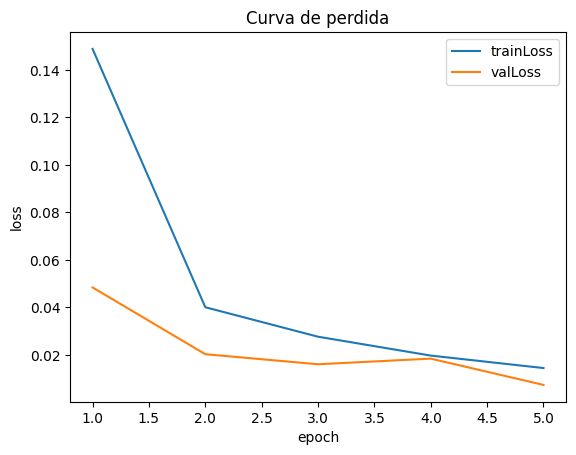

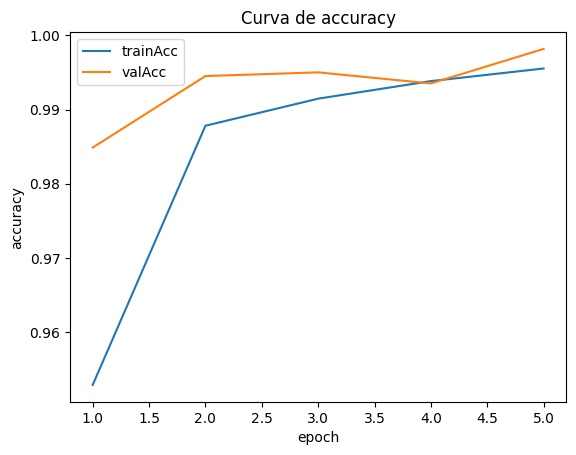

In [47]:
best_idx = dfResults.index[0]
best_cfg = results[best_idx]["config"]
best_hist = results[best_idx]["history"]

epochs = [h["epoch"] for h in best_hist]
train_loss = [h["trainLoss"] for h in best_hist]
val_loss = [h["valLoss"] for h in best_hist]
train_acc = [h["trainAcc"] for h in best_hist]
val_acc = [h["valAcc"] for h in best_hist]

plt.figure()
plt.plot(epochs, train_loss, label="trainLoss")
plt.plot(epochs, val_loss, label="valLoss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Curva de perdida")

plt.figure()
plt.plot(epochs, train_acc, label="trainAcc")
plt.plot(epochs, val_acc, label="valAcc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("Curva de accuracy")

En cinco épocas, todas las configuraciones alcanzaron entre 99.00 y 99.18 de precisión en test, con pérdidas y errores que descienden de forma estable y brechas de generalización por debajo de 1 punto porcentual, lo que indica buen ajuste. Adam con lr=0.001 logró 99.18 de testAcc tanto con fcUnits=\[128] como con \[256,128], pero a costa de mayor tiempo de entrenamiento frente a SGD. Incrementar la capacidad del modelo de 0.42 M a 1.71 M de parámetros apenas aportó 0.05 puntos de mejora, mostrando rendimientos decrecientes en MNIST. Las curvas muestran valAcc ligeramente superior a trainAcc y valLoss inferior a trainLoss, consistente con el uso de dropout en entrenamiento y su desactivación en evaluación. En conjunto, el mejor compromiso precisión–tiempo–tamaño se observa en la configuración convFilters=\[64,128], fcUnits=\[128], Adam 0.001; si el tiempo es crítico, convFilters=\[32,64] con SGD y más épocas puede aproximar ese desempeño con menor costo computacional.

## Mejor modelo del laboratorio anterior

In [54]:
def train_and_evaluate(config, train_loader, test_loader):
    model = build_mlp(784, config["hidden_layers"], 10, config["activation_fn"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    train_losses = []
    val_accuracies = []

    for epoch in range(config["epochs"]):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 🔹 Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(images.size(0), -1).to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = correct / total
        val_accuracies.append(acc)

        print(f"Epoch {epoch+1}/{config['epochs']} - Loss: {avg_loss:.4f}, Val Acc: {acc:.4f}")

    return model, train_losses, val_accuracies


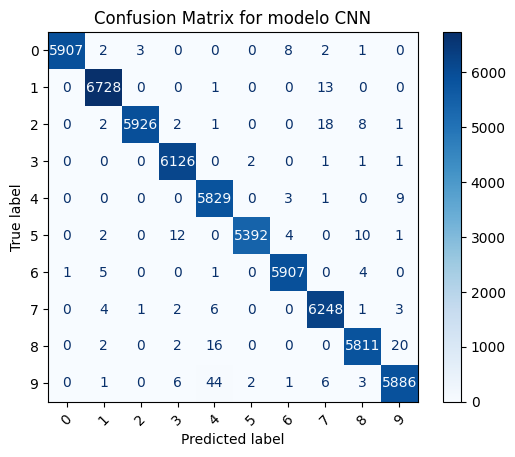

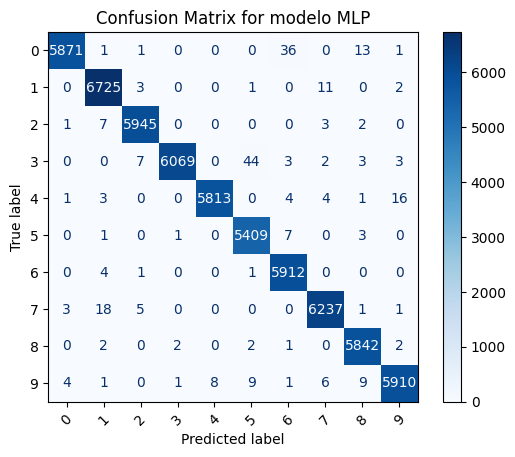

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, testLoader, device, name ,classes=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in testLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classes or list(range(10)))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix for "+ str(name))
    plt.show()

# 👉 Run this after training
plot_confusion_matrix(models[3], train_loader, device, "modelo CNN",classes=[str(i) for i in range(10)],)

plot_confusion_matrix(models[2], train_loader, device,"modelo MLP" ,classes=[str(i) for i in range(10)])


Podemos observar que el mejor modelo del laboratorio anterior que tiene los hiperpárametros mlp_3_wide	[512, 256]	LeakyReLU	0.0005	32	15	98.37
contra una CNN, se observa que el CNN es un modelo con mayor precisión al obtener 98.37 de precisión. Por otro lado observamos que el modelo de CNN tiene pocos parámetros a comparación del mejor modelo anterior en la cual tiene mayor parámetros en las cuales puede afectar con el tiempo de ejecución. Esto se puede demostrar debido a que tiene una precisión de 99.2%


Para la matriz de confusión del modelo CNN observamos que el mayor número que ha predicho erroneamente es el número 9. Lo cúal tiene sentido en la cual podria equivocarse con el número 4 y el número 8 por la curva el circulo que hay. Por otro lado, observamos que en el modelo de la MLP se puede equivocare con el número 6 y 0 por el circulo de abajo. Por otro lado tambien esta el número 3 donde puede confunirse con el semicirculo que existe abajo. Esto tiene sentido debido a que el modelo cnn tiene mayor precisión lo cual si puede acertar la mayoría de los datos.  

## Referencias

- [Datasets PyTorch](https://docs.pytorch.org/vision/stable/datasets.html#mnist)
- [MNIST PyTorch](https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html?highlight=mnist#torchvision.datasets.MNIST)
- [Transforming PyTorch](https://docs.pytorch.org/vision/stable/transforms.html#)
- [DataLoader PyTorch](https://docs.pytorch.org/docs/stable/data.html#)
- [Compose PyTorch](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.v2.Compose.html#torchvision.transforms.v2.Compose)
- [Torch.nn PyTorch](https://docs.pytorch.org/docs/stable/nn.html)
- [MLP PyTorch](https://docs.pytorch.org/vision/main/generated/torchvision.ops.MLP.html)
- [Sequential PyTorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
- [Torch nn](https://docs.pytorch.org/docs/stable/nn.html)
- [Conv2D](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [AvgPool2D](https://docs.pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)
- [Functional AVG Pool2D](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.avg_pool2d.html)
- [MaxPool2D](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- [Functional Max Pool2D](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html)